# 30 Days - Only Linear Regression
Simple linear regression is the simplest and most descriptive model of regression problems. 

Models such as ensembles and deep learning do not know the effects of variables, so they do not know the relationship between how much they affect the target variable. 

Your goal is not to increase the performance of the model, but rather a good model that you can use to identify and explain the effects and influence of variables. 

Since the model is intuitive, a well-made regression model can sometimes expect good performance.

## Load Data & Function & Libarary

In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/30-days-of-ml/sample_submission.csv
/kaggle/input/30-days-of-ml/train.csv
/kaggle/input/30-days-of-ml/test.csv


In [11]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_error

In [12]:
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling

def compare_hist(train_num_scale, test_num_scale):
    for i in range(len(train_num_scale.columns)):
        f, ax = plt.subplots(1, 2, figsize = (10, 5))
        sns.distplot(train_num_scale.iloc[:,i], norm_hist='True', fit=stats.norm, ax=ax[0])
        sns.distplot(test_num_scale.iloc[:,i], norm_hist='True', fit=stats.norm, ax=ax[1])
        
### Functionalize
### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif

### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    RMSE = np.sqrt(((Y_real.values.flatten() - Y_pred)**2).mean())
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, RMSE, MAPE], index=['MAE', 'RMSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)



In [13]:
train = pd.read_csv("/kaggle/input/30-days-of-ml/train.csv", low_memory=False)
test = pd.read_csv("/kaggle/input/30-days-of-ml/test.csv", low_memory=False)
train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

In [14]:
test.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      200000 non-null  int64  
 1   cat0    200000 non-null  object 
 2   cat1    200000 non-null  object 
 3   cat2    200000 non-null  object 
 4   cat3    200000 non-null  object 
 5   cat4    200000 non-null  object 
 6   cat5    200000 non-null  object 
 7   cat6    200000 non-null  object 
 8   cat7    200000 non-null  object 
 9   cat8    200000 non-null  object 
 10  cat9    200000 non-null  object 
 11  cont0   200000 non-null  float64
 12  cont1   200000 non-null  float64
 13  cont2   200000 non-null  float64
 14  cont3   200000 non-null  float64
 15  cont4   200000 non-null  float64
 16  cont5   200000 non-null  float64
 17  cont6   200000 non-null  float64
 18  cont7   200000 non-null  float64
 19  cont8   200000 non-null  float64
 20  cont9   200000 non-null  float64
 21  cont10  20

In [15]:
train

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.20,-0.01,0.67,0.14,0.61,0.40,0.16,0.31,0.39,0.27,0.24,0.38,0.32,0.87,8.11
1,2,B,B,A,A,B,D,A,F,A,O,0.74,0.37,1.02,0.37,0.28,0.53,0.56,0.52,0.59,0.34,0.91,0.92,0.26,0.47,8.48
2,3,A,A,A,C,B,D,A,D,A,F,0.74,0.31,-0.01,0.58,0.29,0.65,0.38,0.90,0.56,0.84,0.75,0.62,0.54,0.76,8.36
3,4,B,B,A,C,B,D,A,E,C,K,0.43,0.62,0.58,0.28,0.28,0.67,0.24,0.73,0.68,0.57,0.35,0.71,0.54,0.28,8.05
4,6,A,A,A,C,B,D,A,E,A,N,1.06,0.37,-0.05,0.23,0.29,0.69,0.42,0.65,0.68,0.96,1.00,0.78,0.63,0.25,7.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499993,B,B,A,A,B,D,A,E,A,I,0.70,0.48,0.30,0.20,0.31,0.77,0.45,0.93,1.01,0.85,0.42,1.06,0.70,0.51,7.95
299996,499996,A,B,A,C,B,B,A,E,E,F,0.45,0.72,0.61,0.60,0.74,0.53,0.51,0.36,0.26,0.43,0.30,0.27,0.58,0.82,7.33
299997,499997,B,B,A,C,B,C,A,E,G,F,0.54,0.06,0.59,0.91,0.28,0.69,0.37,0.36,0.38,0.55,0.66,0.63,0.71,0.25,8.71
299998,499998,A,B,A,C,B,B,A,E,E,I,0.30,0.61,0.29,0.41,0.81,0.34,0.42,0.38,0.47,0.35,0.29,0.61,0.38,0.33,7.23


# Feature engineering and Linear Regression model

I just use only linear regression. So, data should be made available for regression analysis.

Linear regression need only numerical variables. 

Also,there are four assumptions associated with a linear regression model:

1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed.

I separated object and number features.

Then, I just use label and one-hot encoding in object features.
Also, standardization and normalization are used in number features.

In [16]:
# Get number of unique entries in each column with categorical data
object_cols = [col for col in train.columns if train[col].dtype == "object"]

object_nunique = list(map(lambda col: train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('cat0', 2),
 ('cat1', 2),
 ('cat2', 2),
 ('cat3', 4),
 ('cat4', 4),
 ('cat5', 4),
 ('cat8', 7),
 ('cat6', 8),
 ('cat7', 8),
 ('cat9', 15)]

In [17]:
# Get number of unique entries in each column with categorical data
object_cols = [col for col in test.columns if test[col].dtype == "object"]

object_nunique = list(map(lambda col: test[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('cat0', 2),
 ('cat1', 2),
 ('cat2', 2),
 ('cat3', 4),
 ('cat4', 4),
 ('cat5', 4),
 ('cat8', 7),
 ('cat6', 8),
 ('cat7', 8),
 ('cat9', 15)]

We don't have any missing values in the all variable and different values in the objective variable. Nice!!

We can use only numeric variables in linear regression.

In [18]:
train_obj = train[object_cols]
train_num = train.iloc[:,1:-1].drop(object_cols, axis=1)
test_obj = test[object_cols]
test_num = test.iloc[:,1:].drop(object_cols, axis=1)

In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_obj_label = train_obj.copy()
test_obj_label = test_obj.copy()
for i in range(10):
    train_obj_label.iloc[:,i] = encoder.fit_transform(train_obj.iloc[:,i])
    test_obj_label.iloc[:,i] = encoder.fit_transform(test_obj.iloc[:,i])

In [20]:
train_obj = pd.get_dummies(train_obj)
test_obj = pd.get_dummies(test_obj)

In [21]:
list = [1,3,5,9,13,17,24,32,40,55]

train_obj=train_obj.drop(train_obj.columns[list],axis=1)
test_obj=test_obj.drop(test_obj.columns[list],axis=1)

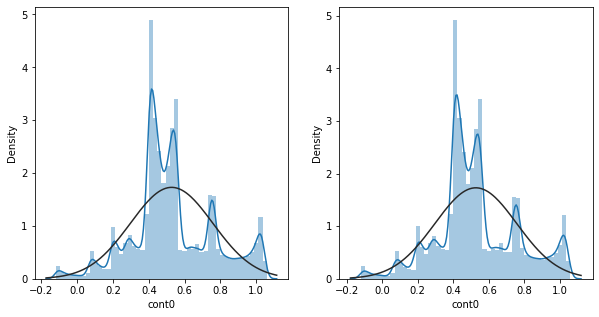

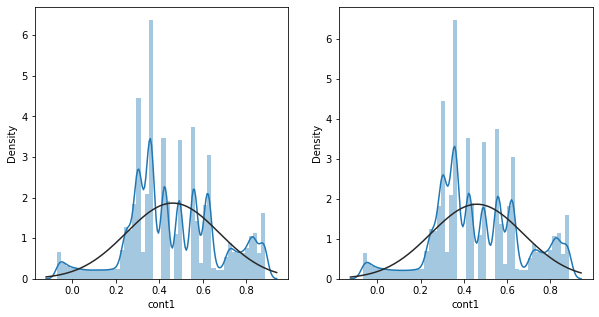

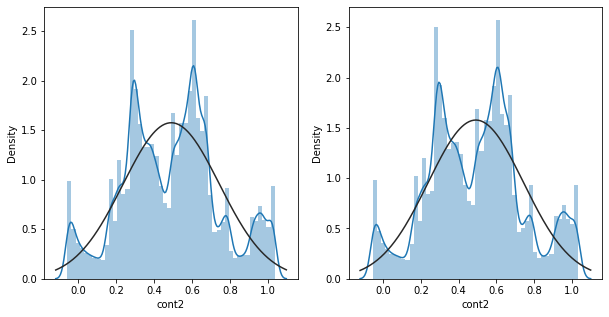

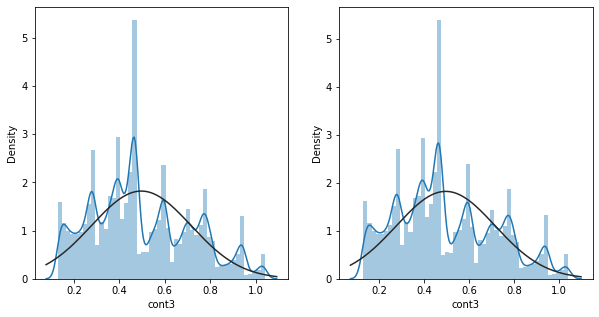

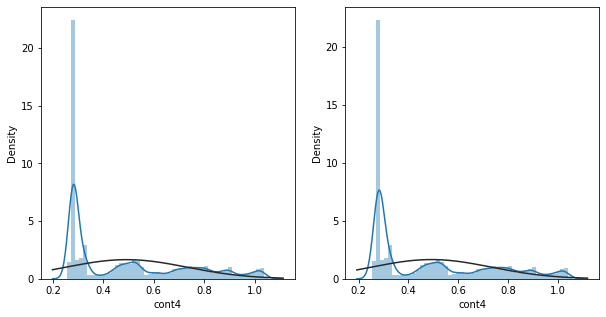

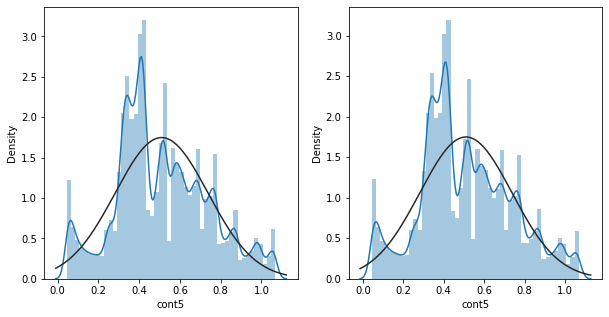

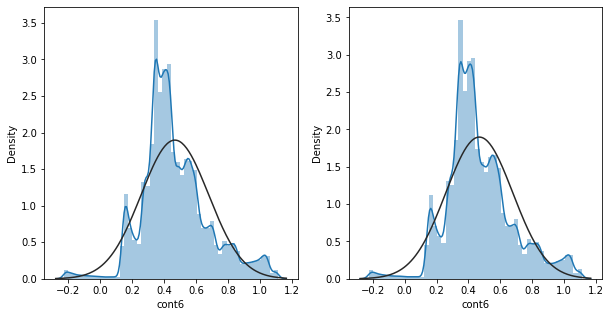

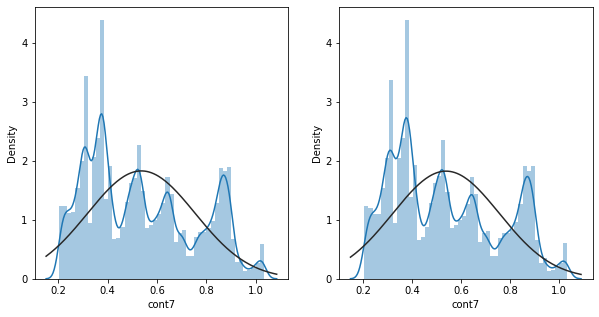

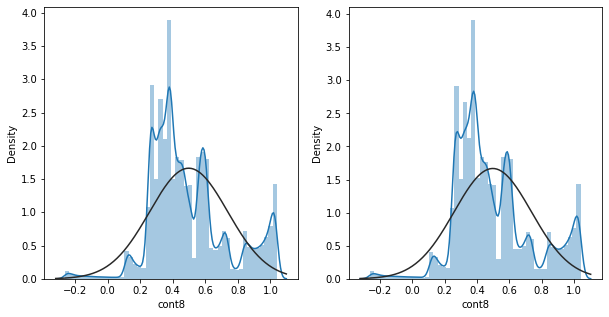

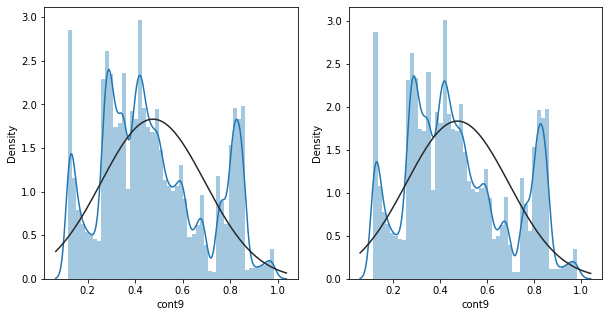

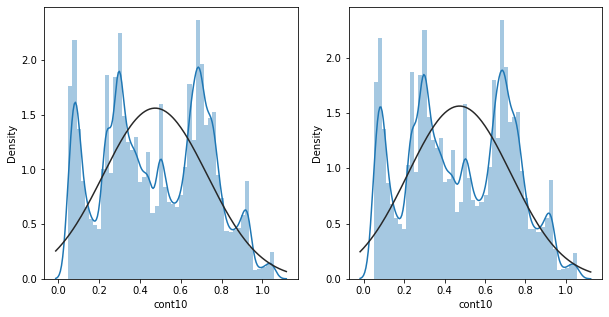

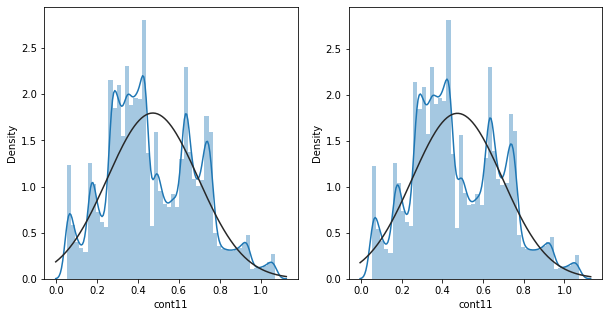

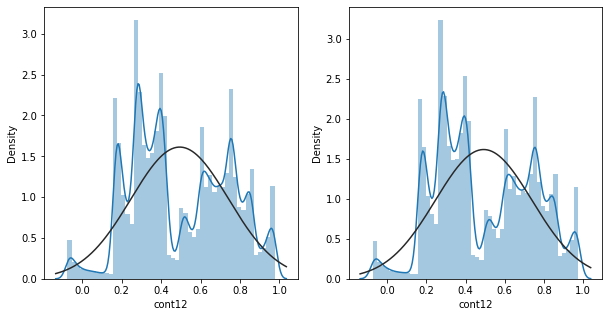

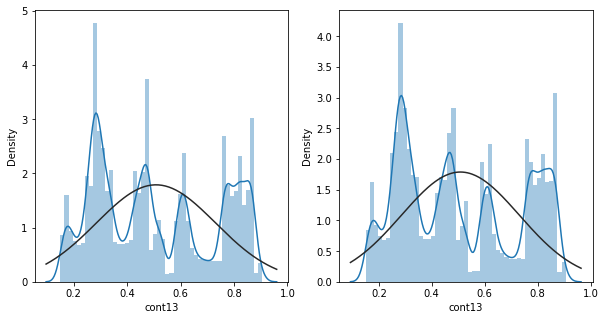

In [22]:
compare_hist(train_num,test_num)

## Normality: For any fixed value of X, Y is normally distributed.

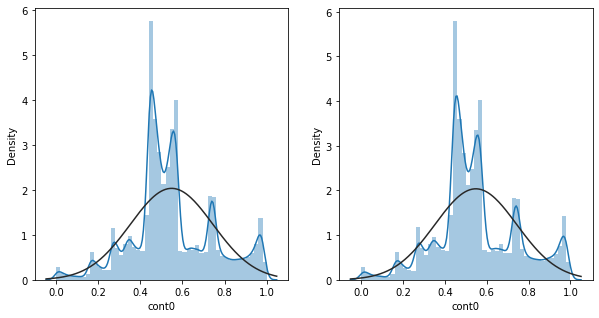

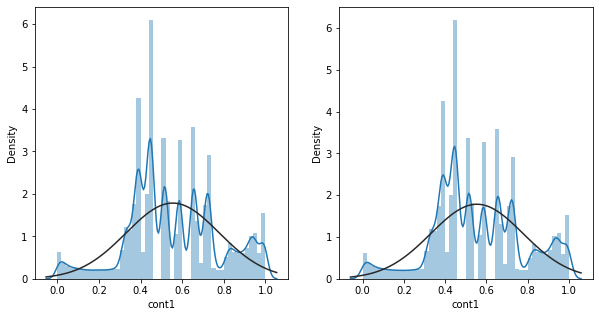

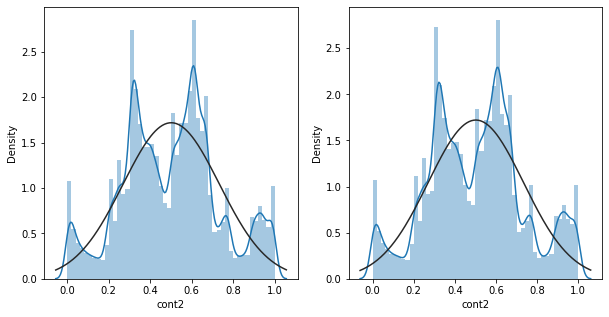

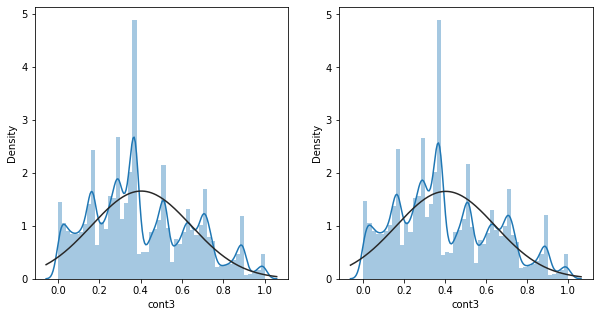

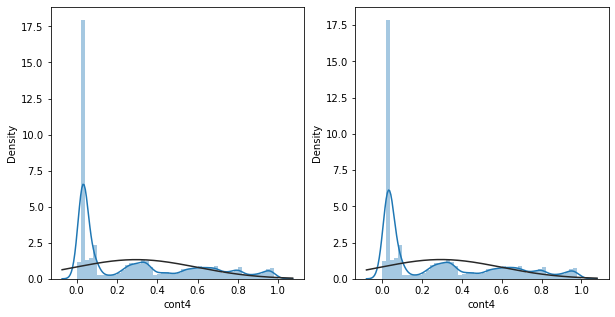

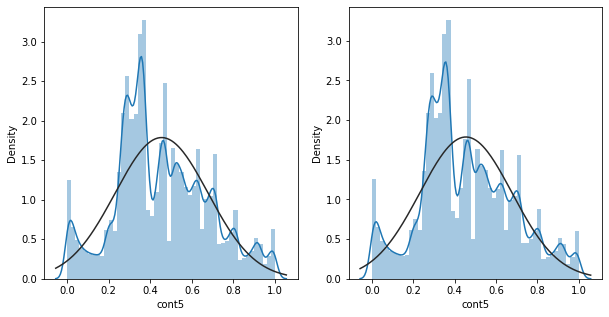

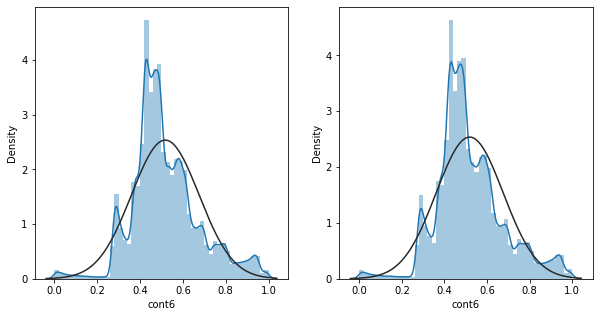

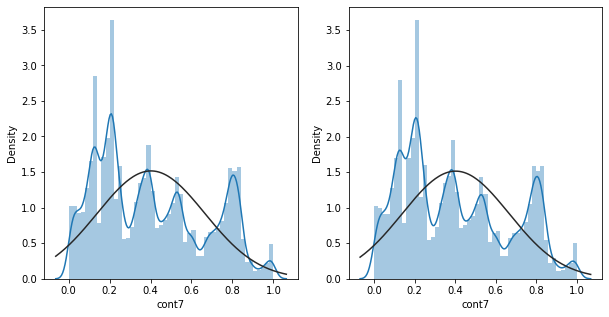

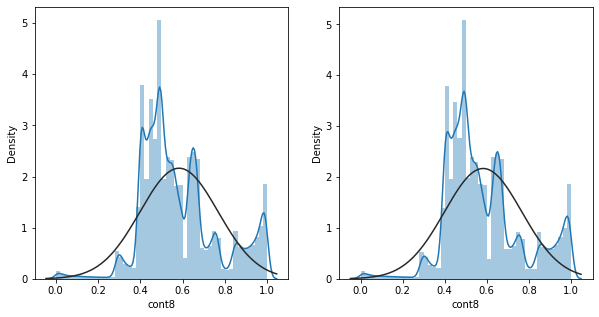

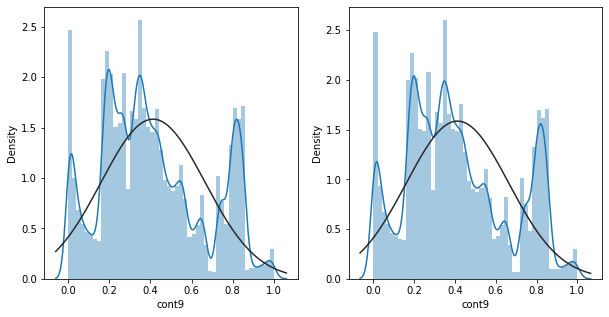

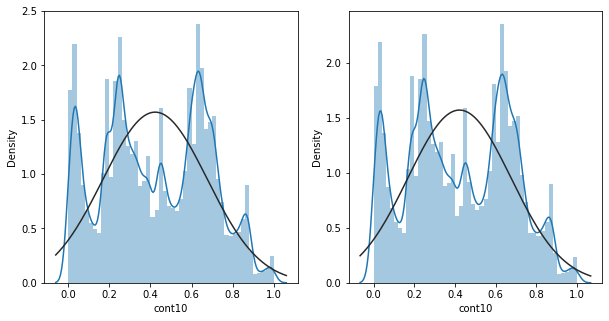

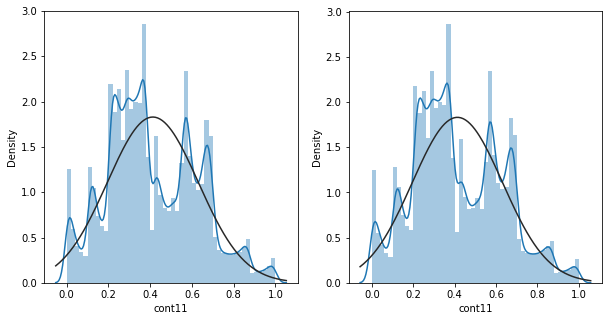

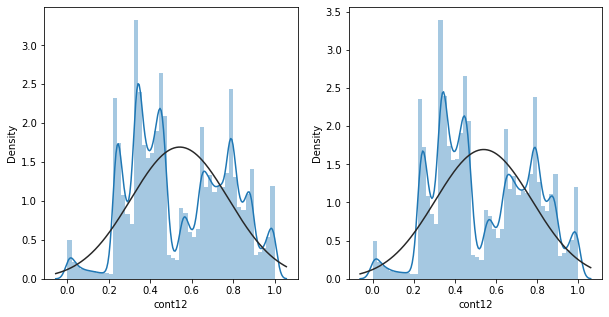

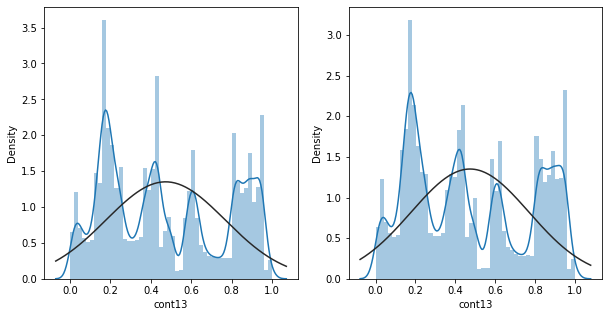

In [23]:
train_num_scale, test_num_scale = feature_engineering_scaling(preprocessing.MinMaxScaler(), train_num, test_num)
compare_hist(train_num_scale,test_num_scale)

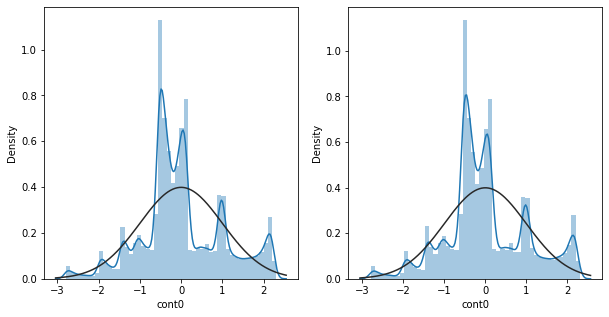

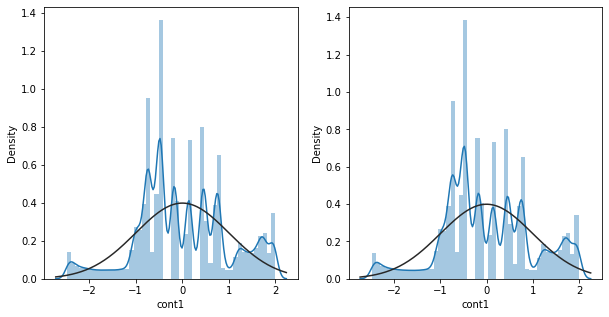

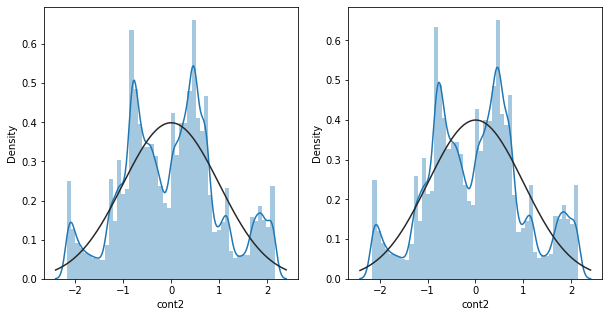

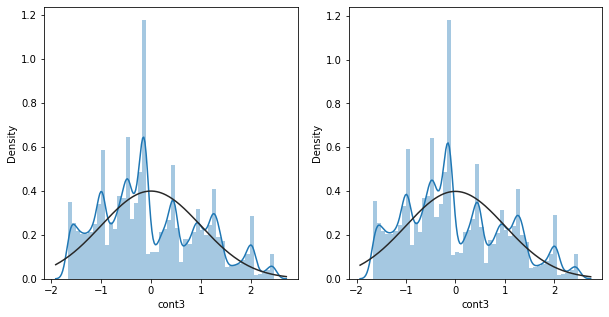

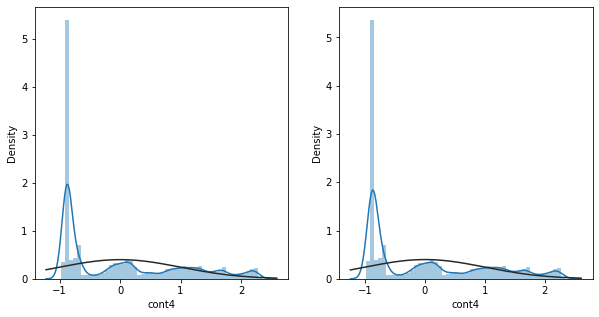

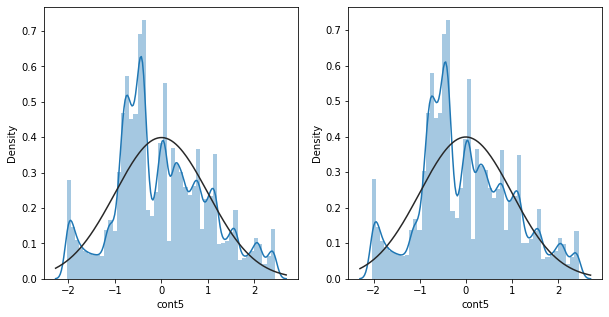

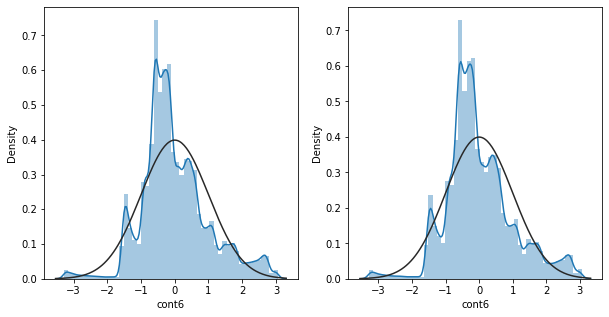

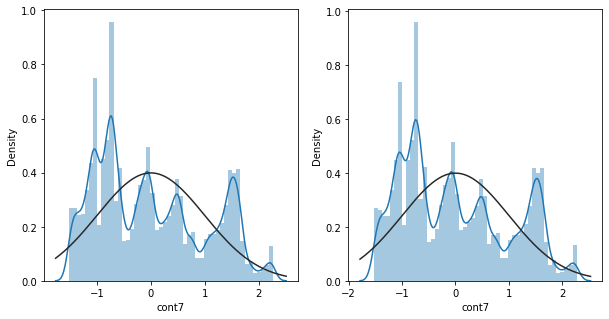

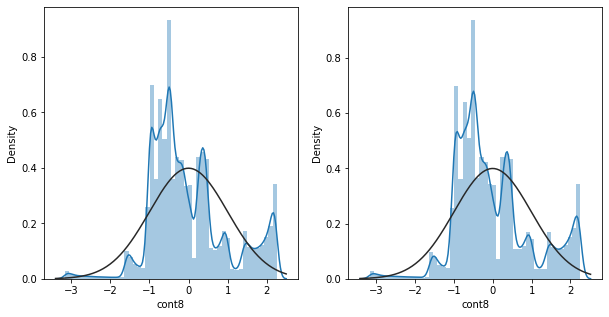

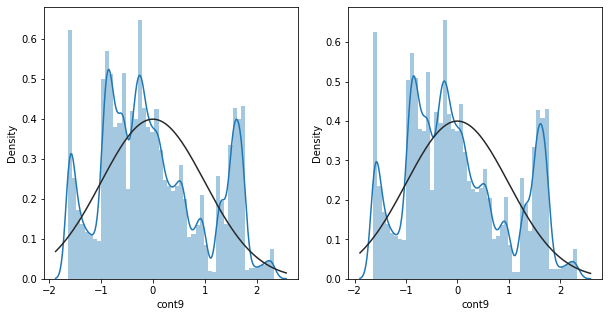

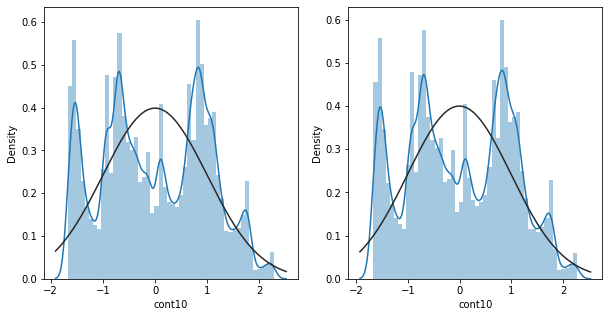

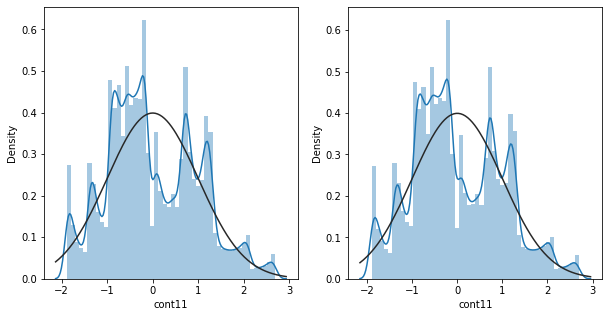

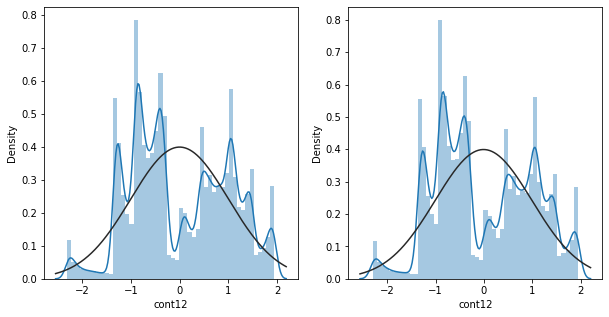

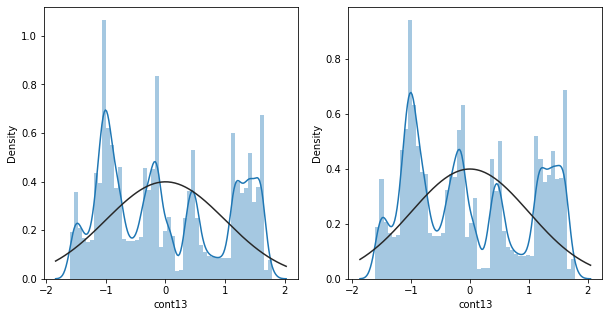

In [24]:
train_num_scale, test_num_scale = feature_engineering_scaling(preprocessing.StandardScaler(), train_num, test_num)
compare_hist(train_num_scale,test_num_scale)

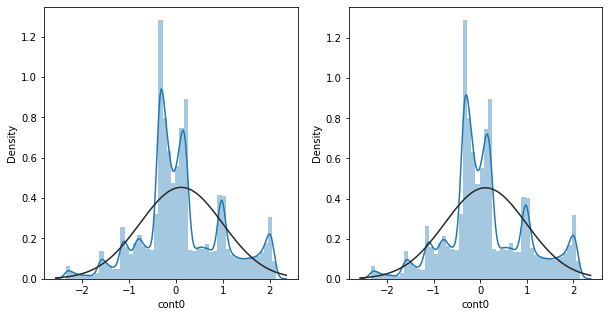

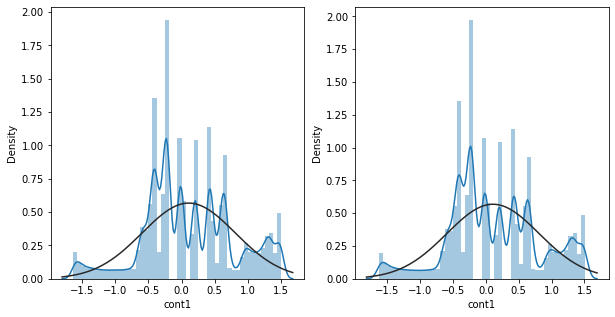

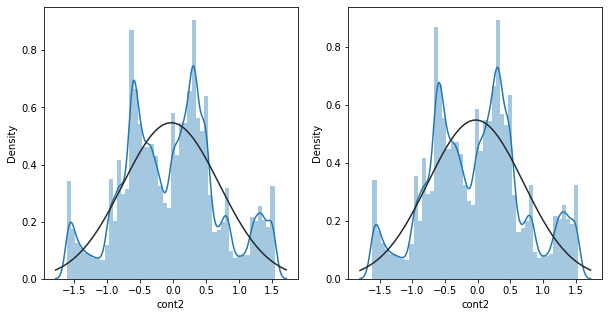

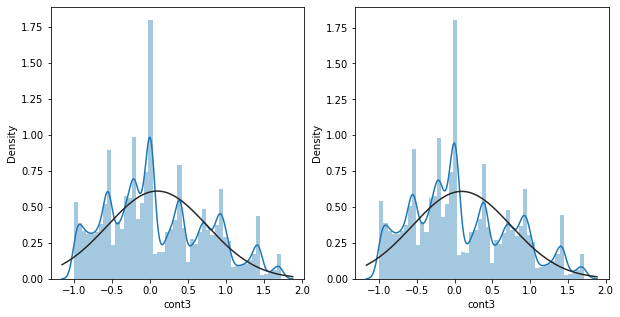

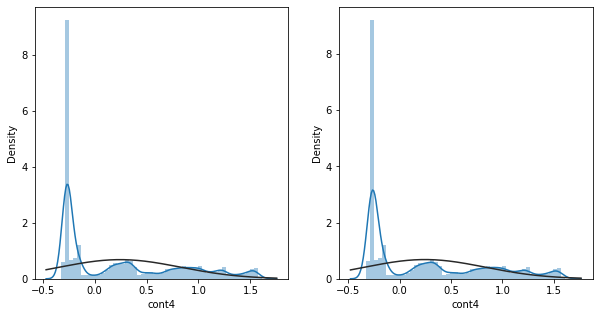

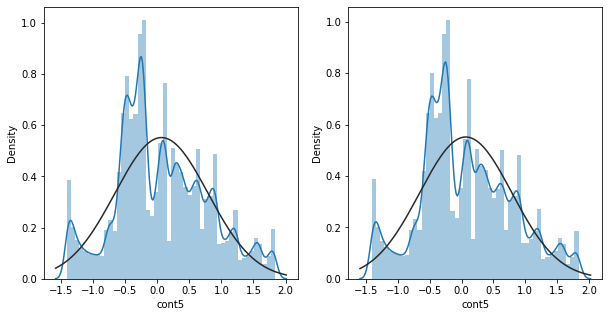

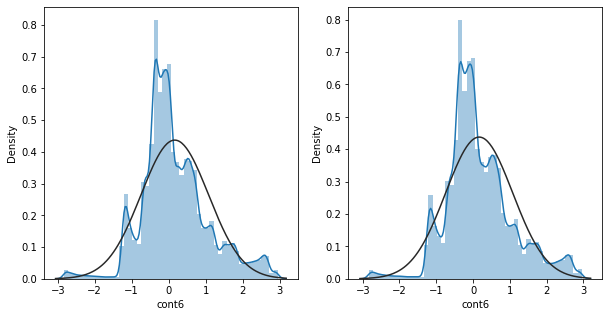

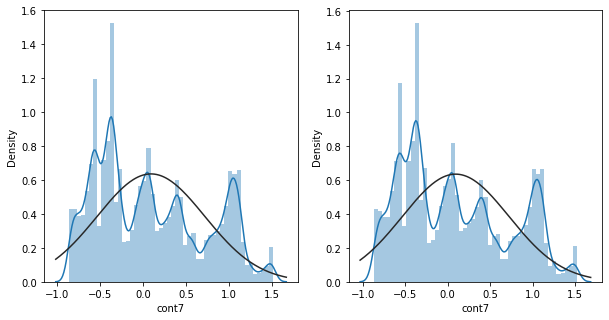

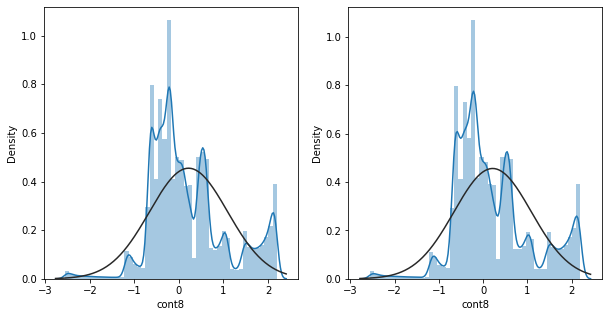

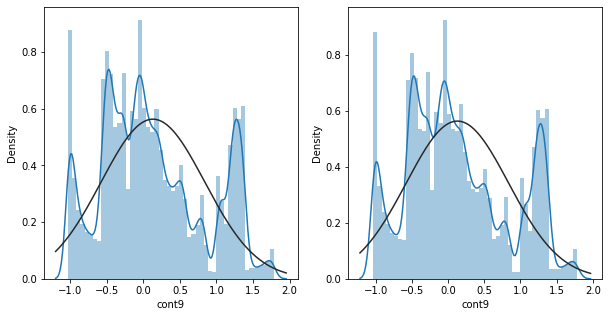

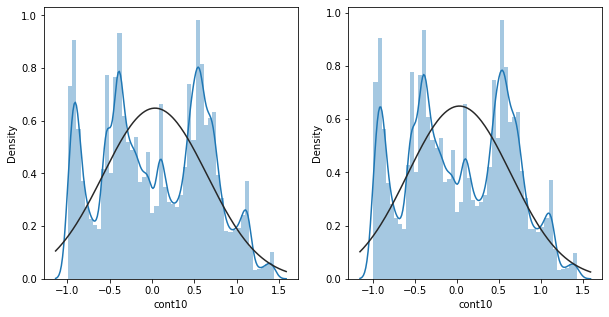

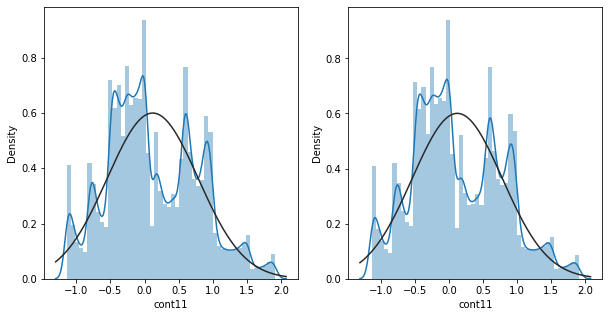

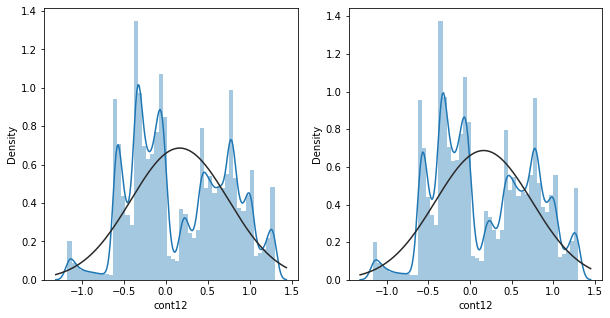

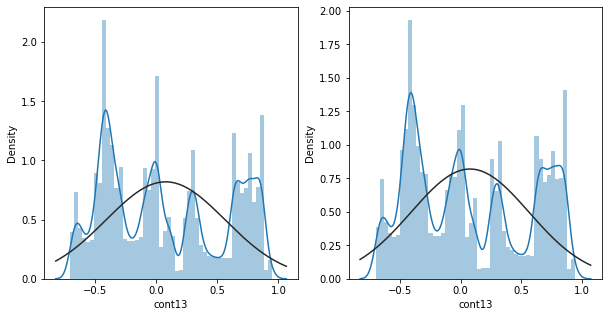

In [25]:
train_num_scale, test_num_scale = feature_engineering_scaling(preprocessing.RobustScaler(), train_num, test_num)
compare_hist(train_num_scale,test_num_scale)

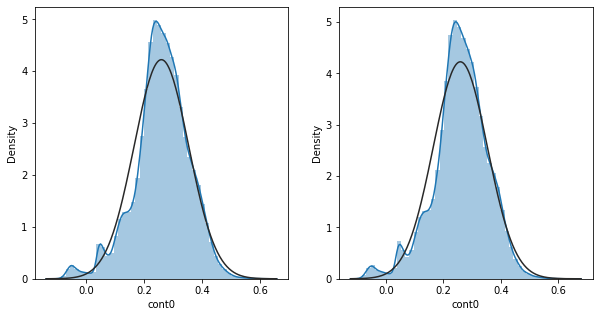

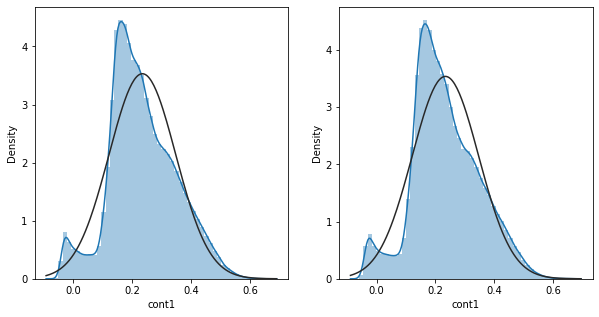

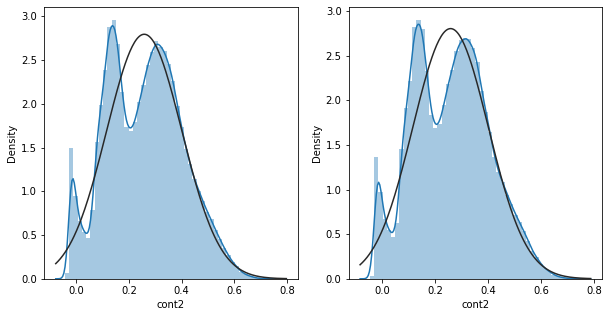

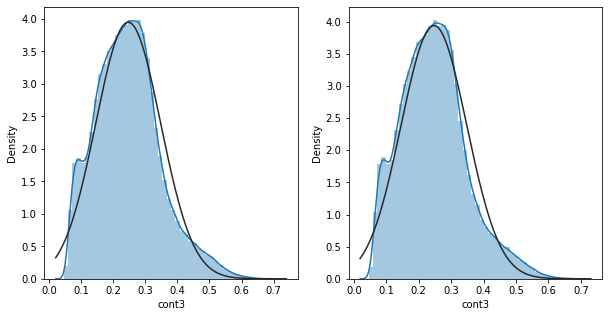

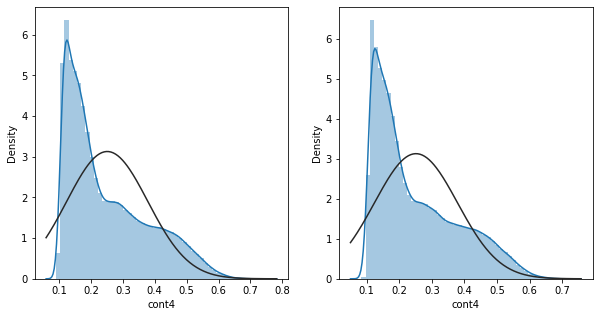

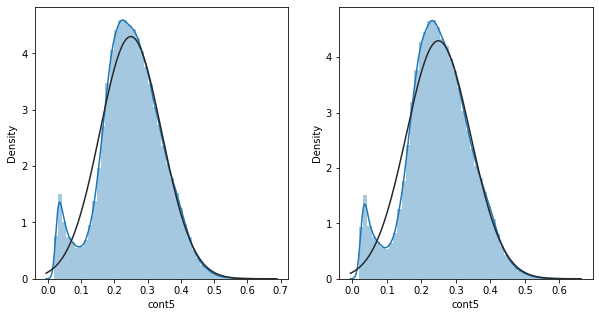

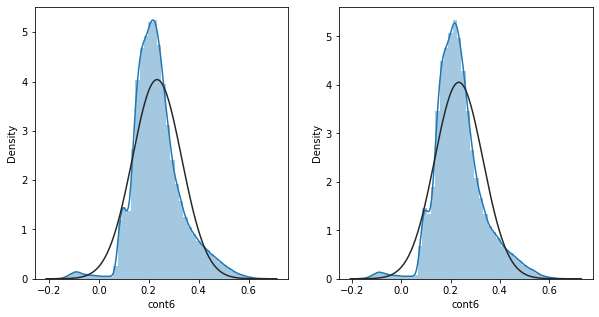

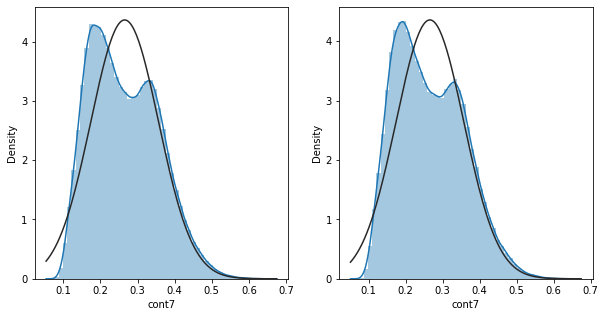

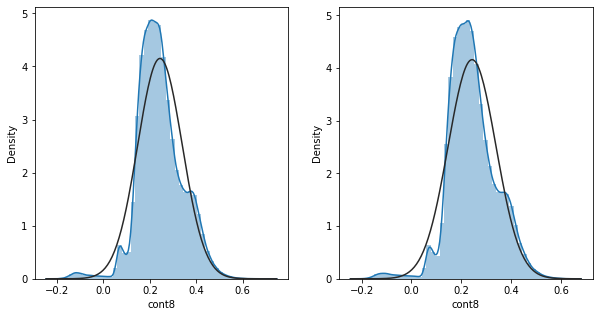

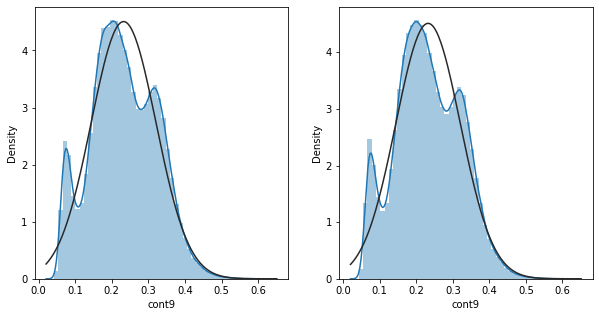

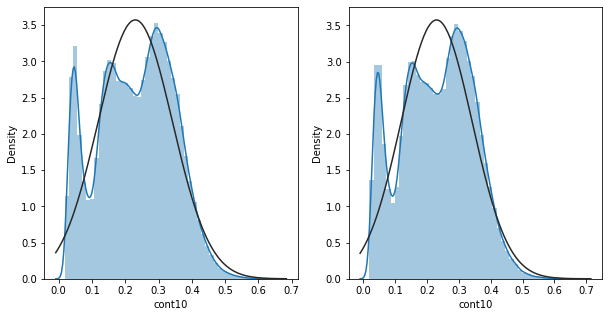

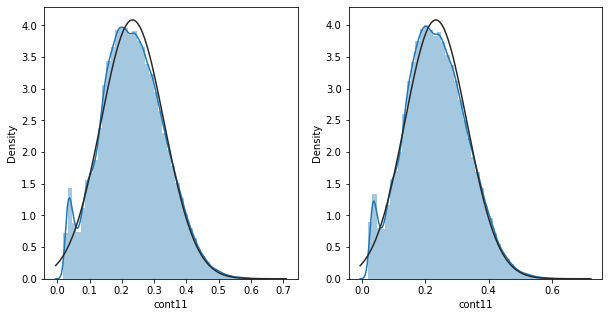

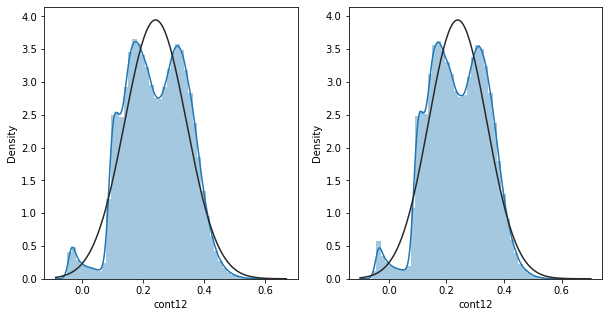

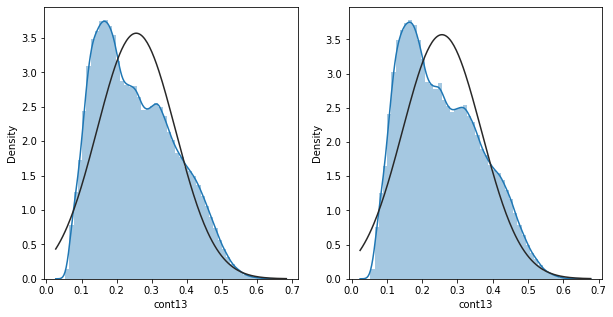

In [26]:
train_num_scale, test_num_scale = feature_engineering_scaling(preprocessing.Normalizer(), train_num, test_num)
compare_hist(train_num_scale,test_num_scale)

Normalizer looks the best graph.

In [85]:
X = pd.concat([train_obj_label, train_num_scale], axis=1)
X_test = pd.concat([test_obj_label, test_num_scale], axis=1)
y = train["target"]

X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.8, random_state=0)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          2.842e+05
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        15:11:19   Log-Likelihood:                         -69672.
No. Observations:               60000   AIC:                                  1.394e+05
Df Residuals:                   59976   BIC:                                  1.396e+05
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0           0.0163      0.007      2.462      0.014       0.003       0.029
cat1          -0.0361      0.007     -5.531      0.000      -0.049      -0.023
cat2           0.0073      0.009      0.802      0.422      -0.010       0.025
cat3           0.0170      0.005      3.420      0.001       0.007       0.027
cat4           0.3002      0.021     14.381      0.000       0.259       0.341
cat5           0.0024      0.004      0.558      0.577      -0.006       0.011
cat6           0.0060      0.011      0.549      0.583      -0.016       0.028
cat7           0.0920      0.006     16.703      0.000       0.081       0.103
cat8           0.0011      0.002      0.634      0.526      -0.002       0.005
cat9           0.0058      0.001      6.223      0.000       0.004       0.008
cont0          2.2334      0.034     66.576      0.000       2.168       2.299
cont1          2.0356      0.028     71.759      0.000       1.980       2.091
cont2          2.7357      0.027    102.916      0.000       2.684       2.788
cont3          2.0062      0.031     65.110      0.000       1.946       2.067
cont4          2.4336      0.027     90.509      0.000       2.381       2.486
cont5          1.6785      0.036     47.261      0.000       1.609       1.748
cont6          1.9781      0.032     62.656      0.000       1.916       2.040
cont7          2.5817      0.034     76.037      0.000       2.515       2.648
cont8          2.2016      0.034     64.093      0.000       2.134       2.269
cont9          1.6717      0.037     45.186      0.000       1.599       1.744
cont10         2.2008      0.030     73.281      0.000       2.142       2.260
cont11         2.3202      0.033     70.871      0.000       2.256       2.384
cont12         2.3921      0.034     69.489      0.000       2.325       2.460
cont13         2.0817      0.028     73.533      0.000       2.026       2.137
==============================================================================
Omnibus:                     1015.816   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1620.613
Skew:                           0.168   Prob(JB):                         0.00
Kurtosis:                       3.732   Cond. No.                         118.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,RMSE,MAPE
Train,0.61,0.77,7.53
Test,0.62,0.78,7.58


0.7753273403838774


In [27]:
X = pd.concat([train_obj, train_num_scale], axis=1)
X_test = pd.concat([test_obj, test_num_scale], axis=1)
y = train["target"]

X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.8, random_state=0)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.240e+05
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        14:06:53   Log-Likelihood:                         -67085.
No. Observations:               60000   AIC:                                  1.343e+05
Df Residuals:                   59940   BIC:                                  1.348e+05
Df Model:                          60                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0_A        -0.0019      0.006     -0.300      0.764      -0.014       0.011
cat1_A         0.0722      0.006     11.468      0.000       0.060       0.085
cat2_A         0.0189      0.009      2.181      0.029       0.002       0.036
cat3_A         0.0688      0.026      2.622      0.009       0.017       0.120
cat3_B         0.0818      0.074      1.107      0.268      -0.063       0.227
cat3_C         0.0292      0.025      1.181      0.237      -0.019       0.078
cat4_A         0.5309      0.078      6.806      0.000       0.378       0.684
cat4_B         0.5260      0.072      7.337      0.000       0.385       0.666
cat4_C         0.5251      0.082      6.405      0.000       0.364       0.686
cat5_A         0.0347      0.026      1.330      0.184      -0.016       0.086
cat5_B         0.0189      0.009      2.136      0.033       0.002       0.036
cat5_C         0.0280      0.013      2.187      0.029       0.003       0.053
cat6_A         6.2634      0.117     53.750      0.000       6.035       6.492
cat6_B         6.2545      0.118     53.022      0.000       6.023       6.486
cat6_C         6.3607      0.129     49.263      0.000       6.108       6.614
cat6_D         6.3739      0.150     42.551      0.000       6.080       6.668
cat6_E         6.2240      0.273     22.808      0.000       5.689       6.759
cat6_G         5.9073      0.537     11.006      0.000       4.855       6.959
cat6_I         6.3145      0.173     36.532      0.000       5.976       6.653
cat7_A         0.0323      0.249      0.130      0.897      -0.455       0.520
cat7_B         0.0351      0.035      1.002      0.316      -0.034       0.104
cat7_C         0.4091      0.249      1.645      0.100      -0.078       0.897
cat7_D         0.0676      0.034      2.018      0.044       0.002       0.133
cat7_E         0.0371      0.030      1.233      0.217      -0.022       0.096
cat7_F         0.0966      0.077      1.258      0.208      -0.054       0.247
cat7_I        -0.1104      0.304     -0.363      0.716      -0.706       0.485
cat8_A         0.0080      0.012      0.675      0.500      -0.015       0.031
cat8_B        -0.0828      0.133     -0.620      0.535      -0.344       0.179
cat8_C         0.0847      0.012      7.004      0.000       0.061       0.108
cat8_D         0.0411      0.026      1.609      0.108      -0.009       0.091
cat8_E         0.0090      0.013      0.698      0.485      -0.016       0.034
cat8_F         0.0420      0.055      0.760      0.447      -0.066       0.150
cat9_A        -0.0164      0.021     -0.779      0.436      -0.058       0.025
cat9_B        -0.0030      0.020     -0.155      0.877      -0.042       0.036
cat9_C        -0.0510      0.044     -1.147      0.251      -

,MAE,RMSE,MAPE
Train,0.58,0.74,7.20
Test,0.59,0.75,7.25


0.7450087440390252


One-hot encoding has better grades than label encoding!!!!

But, detailed interpretation and assumption verification in model are required.

Below is an interpretation of the following regression results:

## First table (regression model result)
- Dep. Variable

    - target variable

- Model

    - Regression Model (OLS here)

- Method

    - To optimize parameters (where LS)

- No. Observations

    - Number of pairs of data used for analysis, number of observations. The above results indicate that regression was performed with 60000 pairs of data.

- DF Residuals

    - The total number of observations is subtracted from the total number of parameters in the regression model. "No.observations - (Df Model + 1).

- DF Model

    - In the example above, there are 60 predictors, so the Df Model is 60. The Df Model is the number of predictors. Usually, the whole parameter contains a dependent variable in regression, so the Df Model subtracts one from the entire variable.


- R-squared (coefficient of determination)

    - It is one of the indicators of how well the model fits the data. We can see that the above data is represented by 0.992 which means R-squared. Simply, it is a figure that expresses how linear (y = x0 * weight + x1 * weight + ...). The range is between 0 and 1 and the model has no explanatory power at all, and the closer it is to 1, the better the model can state the data. Usually, 0.4 or higher is a good model.

- Adj. R-squared

    - Number of parameters, the coefficient of determination adjusted according to the data that helps the model

- F-statistic

    - Is the derived regression expression appropriate? (the closer to 0 the more appropriate)

- Prob(F-statistic)

    - How significant is the regression expression (below 0.05 determines that variables are very relevant)

- AIC (Akaike Information Criterion)

    - Score to evaluate the model based on the number of observations and complexity of the model itself (lower the better)

- BIC (Bayesian Information Criterion)

    - Similar to AIC, but better performance than AIC because there are more penalty terms (lower is better)

## Second table (variable's effect in the model)

- coef(Coefficient)

    - This is an estimate of the coefficients obtained from the data. If you put this in a linear regression model expression, you can assume that the expression 'y = x0 * coef0 + x1 * coef1 + ...' was created. Thise represents the relationship between independent and dependent variables.

- std err

    - Standard error of coefficient estimates; smaller values mean more accurate coefficients

- t

    - Relationship between independent variables and dependent variables (greater values, greater effects)

- P > |t|

    - The significance probability of the independent variable is usually determined to be significant when the independent variable has a 95% confidence, and the significance probability is less than 0.05. In other words, if less than 0.05, it is significant that the independent variable affects the dependent variable.

    - The p-value(significance probability) is defined as the probability of having more extreme results(observation) than the results obtained when assuming 'Null hypothesis' are correct. Typically based on p-value < 0.05 or 0.01. If the calculated p-value is less than the reference value, you reject the null hypothesis, which means that it is extremely unlikely that the null hypothesis will occur.
 

 ## Third table (assumptions in the model)

- Omnibus(D'Angostino's Test)
    - D'Angostino's Test, a normality test that combines asymmetry and kurtosis (a larger value means a normal distribution)

- Skewness
    - Whether the residuals around the mean are symmetrical. The closer to zero, the more symmetrical it is.

- Kurtosis
    - Distribution shape of residuals, bell shape (normal shape), closer to zero (negative is flat, positive is pointy)

- Durbin - Watson
    - Above, it is shown as 2.011. The figure shows the independence of the residuals.

    - If zero, the residuals have positive autocorrelation.
    - Two has self-regardless independence.
    - Four means the residuals have negative autocorrelation.
    - Usually between 1.5 and 2.5 means independent and a regression model is appropriate. If it is close to 0 or 4, it means that the residuals have autocorrelation, so it increases the t, F, and R squares from the real world, distorting meaningless results into meaningful results.
 
- Jarque-Bera(JB)
    - Jacques Vera normality test, the larger the value, the more normal the data was used.

- Cond. No
    - Multicollinearity test, whether there is a correlation between independent variables (considering that there is a multicollinearity problem if there is 10 or more, meaningless if there is 1 variable)

## Multicollinearity
In statistics, multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation, the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.

A VIF is used to verify the following assumptions:

- "10" as the maximum level of VIF (Hair et al., 1995)


Variables with VIFs of 10 or more sequentially were removed.

In [28]:
# extract effective features using variance inflation factor
X_temp=X.drop(['cat6_A','cat4_B','cat3_C','cat7_E'],axis=1)

vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_temp.values, i) 
                     for i in range(X_temp.shape[1])]
vif['Feature'] = X_temp.columns
vif.sort_values(by='VIF_Factor', ascending=True)

,VIF_Factor,Feature
14,1.00,cat6_G
21,1.00,cat7_I
16,1.00,cat7_A
13,1.00,cat6_E
18,1.00,cat7_C
...,...,...
50,7.56,cont8
51,8.14,cont9
42,8.32,cont0
47,8.49,cont5


In [88]:
X = pd.concat([train_obj, train_num_scale], axis=1)
X_test = pd.concat([test_obj, test_num_scale], axis=1)
y = train["target"]

X_train, X_val, Y_train, Y_val = train_test_split(X.drop(['cat6_A','cat4_B','cat3_C','cat7_E'],
                                                         axis=1), y, test_size=0.8, random_state=0)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.218e+05
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        15:16:48   Log-Likelihood:                         -69655.
No. Observations:               60000   AIC:                                  1.394e+05
Df Residuals:                   59944   BIC:                                  1.399e+05
Df Model:                          56                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0_A         0.0150      0.007      2.254      0.024       0.002       0.028
cat1_A         0.0728      0.007     11.081      0.000       0.060       0.086
cat2_A         0.0572      0.009      6.330      0.000       0.040       0.075
cat3_A         0.0375      0.010      3.636      0.000       0.017       0.058
cat3_B         0.0212      0.073      0.291      0.771      -0.122       0.164
cat4_A         0.0173      0.032      0.532      0.595      -0.046       0.081
cat4_C        -0.0116      0.042     -0.277      0.781      -0.093       0.070
cat5_A         0.0523      0.027      1.921      0.055      -0.001       0.106
cat5_B         0.0797      0.009      8.669      0.000       0.062       0.098
cat5_C         0.0463      0.013      3.471      0.001       0.020       0.072
cat6_B        -0.0076      0.019     -0.389      0.697      -0.046       0.031
cat6_C         0.1202      0.058      2.059      0.040       0.006       0.235
cat6_D         0.0728      0.097      0.747      0.455      -0.118       0.264
cat6_E         0.0174      0.258      0.067      0.946      -0.488       0.523
cat6_G        -0.3071      0.547     -0.562      0.574      -1.379       0.765
cat6_I         0.0142      0.133      0.107      0.915      -0.246       0.274
cat7_A        -0.0691      0.258     -0.268      0.789      -0.574       0.436
cat7_B         0.0016      0.020      0.082      0.935      -0.037       0.040
cat7_C         0.3282      0.258      1.274      0.203      -0.177       0.833
cat7_D         0.0483      0.016      2.947      0.003       0.016       0.080
cat7_F         0.0574      0.074      0.778      0.437      -0.087       0.202
cat7_I        -0.1447      0.316     -0.458      0.647      -0.763       0.474
cat8_A         0.0843      0.012      6.838      0.000       0.060       0.108
cat8_B         0.0144      0.139      0.103      0.918      -0.259       0.287
cat8_C         0.1771      0.013     14.106      0.000       0.153       0.202
cat8_D         0.1354      0.027      5.083      0.000       0.083       0.188
cat8_E         0.0999      0.013      7.487      0.000       0.074       0.126
cat8_F         0.1265      0.058      2.197      0.028       0.014       0.239
cat9_A         0.1125      0.022      5.129      0.000       0.070       0.156
cat9_B         0.1328      0.020      6.492      0.000       0.093       0.173
cat9_C         0.0983      0.046      2.122      0.034       0.008       0.189
cat9_D         0.0896      0.055      1.619      0.105      -0.019       0.198
cat9_E         0.1379      0.055      2.499      0.012       0.030       0.246
cat9_F         0.1269      0.016      7.990      0.000       0.096       0.158
cat9_G         0.1254      0.018      7.029      0.000       

,MAE,RMSE,MAPE
Train,0.61,0.77,7.53
Test,0.62,0.78,7.57


0.7751703356459162


The value of Cond. No. is smaller than the previous model.

Next, P>|t| eliminated variables larger than 0.05, making them simpler models.

In [103]:
# reduce model

X = pd.concat([train_obj, train_num_scale], axis=1)
X_test = pd.concat([test_obj, test_num_scale], axis=1)
y = train["target"]

X_train, X_val, Y_train, Y_val = train_test_split(X.drop(['cat6_A','cat4_B','cat3_C','cat7_E',
                            'cat6_E','cat7_B','cat6_I','cat8_B','cat4_C','cat3_B','cat6_B','cat7_A','cat7_I','cat4_A','cat6_G','cat6_D','cat7_F','cat9_D','cat7_C','cat5_A'],
                                                         axis=1), y, test_size=0.8, random_state=0)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.706e+05
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        15:20:02   Log-Likelihood:                         -69660.
No. Observations:               60000   AIC:                                  1.394e+05
Df Residuals:                   59960   BIC:                                  1.398e+05
Df Model:                          40                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0_A         0.0150      0.007      2.261      0.024       0.002       0.028
cat1_A         0.0729      0.007     11.093      0.000       0.060       0.086
cat2_A         0.0572      0.009      6.324      0.000       0.039       0.075
cat3_A         0.0376      0.010      3.654      0.000       0.017       0.058
cat5_B         0.0763      0.009      8.460      0.000       0.059       0.094
cat5_C         0.0441      0.013      3.326      0.001       0.018       0.070
cat6_C         0.1216      0.058      2.082      0.037       0.007       0.236
cat7_D         0.0477      0.016      2.916      0.004       0.016       0.080
cat8_A         0.0841      0.012      6.839      0.000       0.060       0.108
cat8_C         0.1776      0.013     14.189      0.000       0.153       0.202
cat8_D         0.1366      0.027      5.135      0.000       0.084       0.189
cat8_E         0.1003      0.013      7.541      0.000       0.074       0.126
cat8_F         0.1281      0.058      2.225      0.026       0.015       0.241
cat9_A         0.1065      0.022      4.929      0.000       0.064       0.149
cat9_B         0.1267      0.020      6.306      0.000       0.087       0.166
cat9_C         0.0921      0.046      1.997      0.046       0.002       0.183
cat9_E         0.1333      0.055      2.422      0.015       0.025       0.241
cat9_F         0.1206      0.015      7.826      0.000       0.090       0.151
cat9_G         0.1193      0.017      6.844      0.000       0.085       0.154
cat9_H         0.1210      0.019      6.482      0.000       0.084       0.158
cat9_I         0.0994      0.016      6.316      0.000       0.069       0.130
cat9_J         0.0921      0.020      4.543      0.000       0.052       0.132
cat9_K         0.1491      0.019      7.844      0.000       0.112       0.186
cat9_L         0.1202      0.018      6.506      0.000       0.084       0.156
cat9_M         0.0926      0.024      3.877      0.000       0.046       0.139
cat9_N         0.1366      0.020      7.005      0.000       0.098       0.175
cont0          2.3279      0.033     70.617      0.000       2.263       2.393
cont1          2.1038      0.028     75.675      0.000       2.049       2.158
cont2          2.7628      0.027    103.701      0.000       2.711       2.815
cont3          2.1150      0.030     70.955      0.000       2.057       2.173
cont4          2.5176      0.026     97.051      0.000       2.467       2.568
cont5          1.8162      0.035     52.581      0.000       1.749       1.884
cont6          2.0805      0.031     67.763      0.000       2.020       2.141
cont7          2.7211      0.033     82.425      0.000       2.656       2.786
cont8          2.3221      0.033     69.576      0.000       

,MAE,RMSE,MAPE
Train,0.61,0.77,7.53
Test,0.62,0.78,7.57


0.7752344233000095


Although the performance is slightly lower, the problem of multicollinearity has been greatly solved.

- "5" as the maximum level of VIF (Ringle et al., 2015)

In [30]:
# extract effective features using variance inflation factor
X_temp=X.drop(['cat6_A','cat4_B','cat3_C','cat7_E',
               'cont7','cont5','cont0','cont9','cont12','cont8','cat2_A','cont2','cont3','cont11',
              'cont6','cont13','cont4','cont1'],axis=1)

vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_temp.values, i) 
                     for i in range(X_temp.shape[1])]
vif['Feature'] = X_temp.columns
vif.sort_values(by='VIF_Factor', ascending=True)

,VIF_Factor,Feature
13,1.00,cat6_G
20,1.00,cat7_I
15,1.00,cat7_A
12,1.00,cat6_E
17,1.00,cat7_C
14,1.00,cat6_I
11,1.00,cat6_D
3,1.00,cat3_B
19,1.00,cat7_F
10,1.00,cat6_C


In [104]:
X = pd.concat([train_obj, train_num_scale], axis=1)
X_test = pd.concat([test_obj, test_num_scale], axis=1)
y = train["target"]

X_train, X_val, Y_train, Y_val = train_test_split(X.drop(['cat6_A','cat4_B','cat3_C','cat7_E',
               'cont7','cont5','cont0','cont9','cont12','cont8','cat2_A','cont2','cont3','cont11','cont6','cont13','cont4','cont1'],axis=1), y, test_size=0.8, random_state=0)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          4.536e+04
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        15:26:18   Log-Likelihood:                     -1.0726e+05
No. Observations:               60000   AIC:                                  2.146e+05
Df Residuals:                   59958   BIC:                                  2.150e+05
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0_A         0.4988      0.012     41.077      0.000       0.475       0.523
cat1_A         0.5884      0.012     49.183      0.000       0.565       0.612
cat3_A         0.2495      0.019     12.961      0.000       0.212       0.287
cat3_B         0.3489      0.136      2.560      0.010       0.082       0.616
cat4_A         0.2574      0.061      4.242      0.000       0.138       0.376
cat4_C         0.0729      0.078      0.935      0.350      -0.080       0.226
cat5_A         0.5142      0.051     10.155      0.000       0.415       0.613
cat5_B         0.5797      0.015     38.773      0.000       0.550       0.609
cat5_C         0.4602      0.025     18.650      0.000       0.412       0.509
cat6_B         0.1852      0.036      5.081      0.000       0.114       0.257
cat6_C         0.3274      0.109      2.997      0.003       0.113       0.541
cat6_D         0.3734      0.182      2.047      0.041       0.016       0.731
cat6_E         0.6850      0.482      1.420      0.156      -0.260       1.630
cat6_G        -0.0842      1.023     -0.082      0.934      -2.090       1.921
cat6_I         0.4899      0.248      1.973      0.048       0.003       0.977
cat7_A         0.1613      0.482      0.334      0.738      -0.784       1.107
cat7_B         0.4292      0.036     11.764      0.000       0.358       0.501
cat7_C         0.1016      0.482      0.211      0.833      -0.844       1.047
cat7_D         0.5375      0.030     17.659      0.000       0.478       0.597
cat7_F         0.2594      0.138      1.877      0.061      -0.012       0.530
cat7_I         1.5552      0.591      2.633      0.008       0.397       2.713
cat8_A         2.1630      0.021    104.286      0.000       2.122       2.204
cat8_B         1.8633      0.260      7.154      0.000       1.353       2.374
cat8_C         2.2885      0.021    110.073      0.000       2.248       2.329
cat8_D         2.2617      0.049     46.557      0.000       2.166       2.357
cat8_E         2.2225      0.022     99.859      0.000       2.179       2.266
cat8_F         2.2311      0.107     20.804      0.000       2.021       2.441
cat9_A         4.0356      0.036    110.908      0.000       3.964       4.107
cat9_B         3.9905      0.033    119.579      0.000       3.925       4.056
cat9_C         4.0185      0.085     47.542      0.000       3.853       4.184
cat9_D         4.1959      0.102     41.315      0.000       3.997       4.395
cat9_E         3.9693      0.102     39.083      0.000       3.770       4.168
cat9_F         4.0326      0.023    176.012      0.000       3.988       4.078
cat9_G         4.0236      0.027    146.322      0.000       3.970       4.078
cat9_H         3.9654      0.030    130.533      0.000       

,MAE,RMSE,MAPE
Train,1.04,1.45,12.80
Test,1.05,1.45,12.87


1.4496014547164835


In [36]:
# reduce model

X = pd.concat([train_obj, train_num_scale], axis=1)
X_test = pd.concat([test_obj, test_num_scale], axis=1)
y = train["target"]

X_train, X_val, Y_train, Y_val = train_test_split(X.drop(['cat6_A','cat4_B','cat3_C','cat7_E',
               'cont7','cont5','cont0','cont9','cont12','cont8','cat2_A','cont2','cont3','cont11','cont6','cont13','cont4','cont1',
                'cat6_G','cat7_C','cat7_A','cat4_C','cat6_E','cat7_F'],axis=1), y, test_size=0.8, random_state=0)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          5.292e+04
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        14:15:46   Log-Likelihood:                     -1.0727e+05
No. Observations:               60000   AIC:                                  2.146e+05
Df Residuals:                   59964   BIC:                                  2.149e+05
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0_A         0.4987      0.012     41.071      0.000       0.475       0.523
cat1_A         0.5889      0.012     49.234      0.000       0.565       0.612
cat3_A         0.2495      0.019     12.959      0.000       0.212       0.287
cat3_B         0.3497      0.136      2.566      0.010       0.083       0.617
cat4_A         0.2577      0.061      4.247      0.000       0.139       0.377
cat5_A         0.5145      0.051     10.164      0.000       0.415       0.614
cat5_B         0.5791      0.015     38.749      0.000       0.550       0.608
cat5_C         0.4608      0.025     18.676      0.000       0.412       0.509
cat6_B         0.1855      0.036      5.088      0.000       0.114       0.257
cat6_C         0.3281      0.109      3.004      0.003       0.114       0.542
cat6_D         0.3733      0.182      2.046      0.041       0.016       0.731
cat6_I         0.5007      0.248      2.017      0.044       0.014       0.987
cat7_B         0.4285      0.036     11.746      0.000       0.357       0.500
cat7_D         0.5366      0.030     17.633      0.000       0.477       0.596
cat7_I         1.5540      0.591      2.631      0.009       0.396       2.712
cat8_A         2.1633      0.021    104.307      0.000       2.123       2.204
cat8_B         1.8624      0.260      7.150      0.000       1.352       2.373
cat8_C         2.2888      0.021    110.096      0.000       2.248       2.330
cat8_D         2.2614      0.049     46.552      0.000       2.166       2.357
cat8_E         2.2226      0.022     99.870      0.000       2.179       2.266
cat8_F         2.2315      0.107     20.808      0.000       2.021       2.442
cat9_A         4.0364      0.036    110.953      0.000       3.965       4.108
cat9_B         3.9911      0.033    119.608      0.000       3.926       4.056
cat9_C         4.0194      0.085     47.554      0.000       3.854       4.185
cat9_D         4.1971      0.102     41.328      0.000       3.998       4.396
cat9_E         3.9716      0.102     39.108      0.000       3.773       4.171
cat9_F         4.0332      0.023    176.058      0.000       3.988       4.078
cat9_G         4.0240      0.027    146.350      0.000       3.970       4.078
cat9_H         3.9665      0.030    130.591      0.000       3.907       4.026
cat9_I         4.0260      0.024    170.651      0.000       3.980       4.072
cat9_J         4.0224      0.034    119.772      0.000       3.957       4.088
cat9_K         4.0347      0.031    130.059      0.000       3.974       4.095
cat9_L         3.9741      0.030    132.872      0.000       3.916       4.033
cat9_M         3.9332      0.041     95.334      0.000       3.852       4.014
cat9_N         4.0340      0.032    125.882      0.000       

,MAE,RMSE,MAPE
Train,1.04,1.45,12.80
Test,1.05,1.45,12.87


1.449751418142338


When only variables with a VIF of 5 or less were selected, their performance was significantly lower than before. In regression analysis, it seems important for the analyst to set a good threshold for each assumption.

## Backward FeatureSelection
If you put performance first, try this variable selection method.

In [23]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from sklearn.linear_model import LinearRegression

lr=LinearRegression() 
sfs1 = SFS(lr, 
           k_features=10, 
           forward=False, 
           floating=True, 
           verbose=2, 
           n_jobs=1,
           cv=5,
           scoring='neg_root_mean_squared_error') 

sfs1 = sfs1.fit(X, y) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.1min finished

[2021-08-27 00:08:34] Features: 59/10 -- score: -0.738148973102129[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished

[2021-08-27 00:11:38] Features: 58/10 -- score: -0.7381417966612519[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n

**[2021-08-27 00:59:17] Features: 39/10 -- score: -0.7380876945372996[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.**

**[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s**

**[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.3min finished**

**[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.**

**[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s**

**[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   41.9s finished**

In [106]:
feature = ['cat0_A', 'cat1_A', 'cat2_A', 'cat3_B', 'cat3_C', 'cat4_A', 'cat4_C', 'cat5_B', 'cat5_C', 'cat6_B',
 'cat6_C', 'cat6_D', 'cat7_C', 'cat7_F', 'cat7_I', 'cat8_A', 'cat8_B', 'cat8_C', 'cat8_E', 'cat9_A', 'cat9_E',
 'cat9_F', 'cat9_I', 'cat9_J', 'cat9_K', 'cat9_M', 'cont0', 'cont1', 'cont2', 'cont3', 'cont5', 'cont6', 'cont7',
 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']

In [54]:
X = pd.concat([train_obj, train_num_scale], axis=1)
X_test = pd.concat([test_obj, test_num_scale], axis=1)
y = train["target"]

X_train, X_val, Y_train, Y_val = train_test_split(X[feature], y, test_size=0.8, random_state=0)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          1.494e+05
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        06:09:28   Log-Likelihood:                         -74350.
No. Observations:               60000   AIC:                                  1.488e+05
Df Residuals:                   59961   BIC:                                  1.491e+05
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0_A         0.0446      0.007      6.223      0.000       0.031       0.059
cat1_A         0.0775      0.007     10.918      0.000       0.064       0.091
cat2_A         0.1218      0.010     12.499      0.000       0.103       0.141
cat3_B         0.1668      0.079      2.104      0.035       0.011       0.322
cat3_C         0.1323      0.010     12.714      0.000       0.112       0.153
cat4_A         0.0497      0.035      1.417      0.156      -0.019       0.118
cat4_C         0.0114      0.045      0.252      0.801      -0.077       0.100
cat5_B         0.2805      0.009     29.605      0.000       0.262       0.299
cat5_C         0.1376      0.014      9.612      0.000       0.110       0.166
cat6_B         0.0117      0.021      0.553      0.580      -0.030       0.053
cat6_C         0.1021      0.063      1.618      0.106      -0.022       0.226
cat6_D         0.1549      0.105      1.470      0.142      -0.052       0.361
cat7_C         0.2982      0.279      1.070      0.285      -0.248       0.844
cat7_F         0.0373      0.080      0.468      0.640      -0.119       0.194
cat7_I        -0.2569      0.341     -0.753      0.452      -0.926       0.412
cat8_A         0.1637      0.012     13.272      0.000       0.140       0.188
cat8_B         0.1335      0.150      0.887      0.375      -0.161       0.428
cat8_C         0.3238      0.012     26.534      0.000       0.300       0.348
cat8_E         0.2624      0.013     20.127      0.000       0.237       0.288
cat9_A         0.0309      0.019      1.663      0.096      -0.006       0.067
cat9_E         0.0846      0.058      1.464      0.143      -0.029       0.198
cat9_F         0.0289      0.009      3.217      0.001       0.011       0.046
cat9_I         0.0116      0.009      1.232      0.218      -0.007       0.030
cat9_J        -0.0022      0.017     -0.130      0.897      -0.035       0.031
cat9_K         0.0585      0.015      3.927      0.000       0.029       0.088
cat9_M         0.0225      0.022      1.041      0.298      -0.020       0.065
cont0          2.4538      0.036     68.996      0.000       2.384       2.524
cont1          2.2337      0.030     75.016      0.000       2.175       2.292
cont2          3.0138      0.028    106.773      0.000       2.958       3.069
cont3          2.2168      0.032     69.247      0.000       2.154       2.280
cont5          1.7891      0.037     48.098      0.000       1.716       1.862
cont6          2.2340      0.033     67.818      0.000       2.169       2.299
cont7          2.8533      0.035     80.399      0.000       2.784       2.923
cont8          2.4380      0.036     67.784      0.000       2.367       2.508
cont9          1.8784      0.039     48.006      0.000       

,MAE,RMSE,MAPE
Train,0.66,0.84,8.15
Test,0.67,0.84,8.18


0.8377319455641423


In [121]:
# reduce model
X = pd.concat([train_obj, train_num_scale], axis=1)
X_test = pd.concat([test_obj, test_num_scale], axis=1)
y = train["target"]

X_train, X_val, Y_train, Y_val = train_test_split(X[feature].drop(['cat4_C','cat6_B','cat7_F','cat9_J','cat7_I','cat8_B','cat9_M','cat7_C','cat9_I','cat4_A','cat9_E','cat9_A','cat6_D','cat6_C'],axis=1), y, test_size=0.8, random_state=0)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          2.331e+05
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        15:36:47   Log-Likelihood:                         -74358.
No. Observations:               60000   AIC:                                  1.488e+05
Df Residuals:                   59975   BIC:                                  1.490e+05
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0_A         0.0448      0.007      6.251      0.000       0.031       0.059
cat1_A         0.0777      0.007     10.942      0.000       0.064       0.092
cat2_A         0.1219      0.010     12.509      0.000       0.103       0.141
cat3_B         0.1669      0.079      2.105      0.035       0.012       0.322
cat3_C         0.1323      0.010     12.711      0.000       0.112       0.153
cat5_B         0.2805      0.009     29.613      0.000       0.262       0.299
cat5_C         0.1384      0.014      9.675      0.000       0.110       0.166
cat8_A         0.1631      0.012     13.241      0.000       0.139       0.187
cat8_C         0.3234      0.012     26.545      0.000       0.299       0.347
cat8_E         0.2618      0.013     20.120      0.000       0.236       0.287
cat9_F         0.0228      0.008      2.794      0.005       0.007       0.039
cat9_K         0.0523      0.014      3.623      0.000       0.024       0.081
cont0          2.4550      0.036     69.078      0.000       2.385       2.525
cont1          2.2365      0.030     75.158      0.000       2.178       2.295
cont2          3.0162      0.028    106.956      0.000       2.961       3.071
cont3          2.2197      0.032     69.385      0.000       2.157       2.282
cont5          1.7911      0.037     48.179      0.000       1.718       1.864
cont6          2.2363      0.033     67.977      0.000       2.172       2.301
cont7          2.8563      0.035     80.561      0.000       2.787       2.926
cont8          2.4394      0.036     67.846      0.000       2.369       2.510
cont9          1.8813      0.039     48.110      0.000       1.805       1.958
cont10         2.3033      0.031     73.618      0.000       2.242       2.365
cont11         2.5101      0.034     73.312      0.000       2.443       2.577
cont12         2.5239      0.036     70.153      0.000       2.453       2.594
cont13         2.2823      0.029     77.631      0.000       2.225       2.340
==============================================================================
Omnibus:                      802.539   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.984
Skew:                           0.195   Prob(JB):                    9.97e-229
Kurtosis:                       3.518   Cond. No.                         44.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,RMSE,MAPE
Train,0.66,0.84,8.15
Test,0.67,0.84,8.19


0.8378861382673063


There are still some assumptions that are violated, but there are some things that we can see as a result of:
- Variables that affect the target variable a lot : cat0_A, cat1_A, cat5_B, cat5_C, cat8_A, cat8_C, cat8_E, cat9_F, cat9_K, cont10
- Variables that do not affect the target variable much : cat6_A, cat4_B, cat7_E, cat6_E, cat7_A, cat6_G, 

# Dimensionality reduction
Dimension reduction, is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data, ideally close to its intrinsic dimension. Working in high-dimensional spaces can be undesirable for many reasons; raw data are often sparse as a consequence of the curse of dimensionality, and analyzing the data is usually computationally intractable. Dimensionality reduction is common in fields that deal with large numbers of observations and/or large numbers of variables.

We intend to use the following methods to solve the multicollinearity problem. Continuous variables are converted through PCA and categorical variables are converted using MCA. The PCA is a distance-based dimension reduction that squares the data on the nearest axis. At this time, standardization and normalization processes are needed to prevent the effects of certain variables from increasing. MCA uses one-hot encoded variables as a measure of distance using a chi-square distribution to reduce dimensions of categorical variables.

In [56]:
!pip install prince

In [58]:
train_obj_ = train[object_cols]
test_obj_ = test[object_cols]

In [61]:
import prince
mca = prince.MCA(n_components=-1)
mca = mca.fit(train_obj_)
train_obj_mca = mca.transform(train_obj_)
test_obj_mca = mca.transform(test_obj_)

In [66]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')
train_reduction=pd.concat([train_obj_mca,train_num_scale],axis=1)
test_reduction=pd.concat([test_obj_mca,test_num_scale],axis=1)

pca.fit(train_reduction)
train_reduction = pd.DataFrame((pca.transform(train_reduction)))
test_reduction = pd.DataFrame((pca.transform(test_reduction)))

In [84]:
X_train, X_val, Y_train, Y_val = train_test_split(train_reduction.drop([10,11,13,14,15,16,17,20],axis=1), y, test_size=0.8, random_state=0)
X_train, X_val = feature_engineering_scaling(preprocessing.Normalizer(), X_train, X_val)

# Applying Base Model
fit_reg2_rd = sm.OLS(Y_train, X_train).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_train).values
pred_te_reg2_rd = fit_reg2_rd.predict(X_val).values

# Evaluation
Score_reg2_rd, Resid_tr_reg2_rd, Resid_te_reg2_rd = evaluation_trte(Y_train, pred_tr_reg2_rd, 
                                                                Y_val, pred_te_reg2_rd, graph_on=False)
display(Score_reg2_rd)
print(Score_reg2_rd.iloc[1,1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.042
Method:                 Least Squares   F-statistic:                              187.3
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        15:07:10   Log-Likelihood:                     -2.1067e+05
No. Observations:               60000   AIC:                                  4.214e+05
Df Residuals:                   59986   BIC:                                  4.215e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.9078      0.061    -14.974      0.000      -1.027      -0.789
1              4.1852      0.109     38.438      0.000       3.972       4.399
2             -1.7076      0.109    -15.616      0.000      -1.922      -1.493
3              1.8510      0.142     13.058      0.000       1.573       2.129
4             -2.8211      0.147    -19.236      0.000      -3.109      -2.534
5              2.1769      0.117     18.599      0.000       1.947       2.406
6             -1.1268      0.147     -7.653      0.000      -1.415      -0.838
7             -1.3107      0.126    -10.380      0.000      -1.558      -1.063
8             -0.9114      0.174     -5.225      0.000      -1.253      -0.569
9             -0.6970      0.193     -3.609      0.000      -1.076      -0.318
12            -0.7520      0.213     -3.524      0.000      -1.170      -0.334
18            -0.6258      0.260     -2.407      0.016      -1.135      -0.116
19            -0.7947      0.263     -3.024      0.002      -1.310      -0.280
21            -4.7888      0.806     -5.939      0.000      -6.369      -3.208
==============================================================================
Omnibus:                     2158.660   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2398.450
Skew:                           0.488   Prob(JB):                         0.00
Kurtosis:                       3.091   Cond. No.                         13.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,RMSE,MAPE
Train,7.90,8.10,95.72
Test,7.89,8.10,95.74


8.100466404576416


The assumptions of regression analysis were well satisfied, but the explanatory power of the regression model decreased significantly, resulting in poor results.

In conclusion, the performance of the model with one-hot encoding and normalization and without variable selection was the best. But it's too early to be disappointed that we know which variables are important and not important to the target. I also learned about the relationship between them. While improving scores is also important, it is important to keep in mind that explaining the relationships and influences between variables in the policy and decision-making process is also an important role as a data scientist.

In [136]:
X = pd.concat([train_obj, train_num_scale], axis=1)
X_test = pd.concat([test_obj, test_num_scale], axis=1)
y = train["target"]

# Applying Base Model
fit_reg2_rd = sm.OLS(y, X).fit()
display(fit_reg2_rd.summary())
pred_tr_reg2_rd = fit_reg2_rd.predict(X_test).values

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          6.141e+05
Date:                Fri, 27 Aug 2021   Prob (F-statistic):                        0.00
Time:                        16:15:56   Log-Likelihood:                     -3.3682e+05
No. Observations:              300000   AIC:                                  6.738e+05
Df Residuals:                  299940   BIC:                                  6.744e+05
Df Model:                          60                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat0_A        -0.0041      0.003     -1.422      0.155      -0.010       0.002
cat1_A         0.0735      0.003     25.979      0.000       0.068       0.079
cat2_A         0.0149      0.004      3.834      0.000       0.007       0.023
cat3_A         0.0799      0.012      6.655      0.000       0.056       0.103
cat3_B         0.1558      0.033      4.773      0.000       0.092       0.220
cat3_C         0.0390      0.011      3.439      0.001       0.017       0.061
cat4_A         0.6582      0.034     19.194      0.000       0.591       0.725
cat4_B         0.6046      0.031     19.196      0.000       0.543       0.666
cat4_C         0.6671      0.036     18.481      0.000       0.596       0.738
cat5_A         0.0214      0.012      1.837      0.066      -0.001       0.044
cat5_B         0.0254      0.004      6.421      0.000       0.018       0.033
cat5_C         0.0286      0.006      4.999      0.000       0.017       0.040
cat6_A         5.8058      0.050    115.573      0.000       5.707       5.904
cat6_B         5.8284      0.051    114.502      0.000       5.729       5.928
cat6_C         5.8511      0.056    104.809      0.000       5.742       5.961
cat6_D         5.8518      0.067     87.932      0.000       5.721       5.982
cat6_E         5.8546      0.122     48.070      0.000       5.616       6.093
cat6_G         5.6885      0.205     27.759      0.000       5.287       6.090
cat6_I         5.8254      0.081     71.647      0.000       5.666       5.985
cat7_A         0.0885      0.134      0.659      0.510      -0.175       0.352
cat7_B         0.0995      0.016      6.201      0.000       0.068       0.131
cat7_C         0.2800      0.125      2.245      0.025       0.036       0.524
cat7_D         0.0980      0.015      6.375      0.000       0.068       0.128
cat7_E         0.0983      0.014      7.083      0.000       0.071       0.125
cat7_F         0.1475      0.034      4.305      0.000       0.080       0.215
cat7_I        -0.0962      0.167     -0.576      0.564      -0.423       0.231
cat8_A        -0.0118      0.005     -2.209      0.027      -0.022      -0.001
cat8_B        -0.0438      0.055     -0.803      0.422      -0.151       0.063
cat8_C         0.0649      0.005     11.929      0.000       0.054       0.076
cat8_D         0.0274      0.011      2.395      0.017       0.005       0.050
cat8_E        -0.0146      0.006     -2.518      0.012      -0.026      -0.003
cat8_F        -0.0174      0.024     -0.715      0.475      -0.065       0.030
cat9_A         0.0212      0.009      2.246      0.025       0.003       0.040
cat9_B         0.0280      0.009      3.192      0.001       0.011       0.045
cat9_C         0.0046      0.020      0.236      0.814      -

In [133]:
submission = pd.read_csv("/kaggle/input/30-days-of-ml/sample_submission.csv", low_memory=False)

In [137]:
submission.iloc[:,1]=pred_tr_reg2_rd

In [138]:
submission.to_csv('submission_linear_regression.csv',index=False)

0.74278